In [6]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
# import torch
import matplotlib.pyplot as plt

import os
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')

In [54]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [28]:
# 영화 id를 영화 제목으로
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [29]:
len(movies_list)

3883

In [30]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


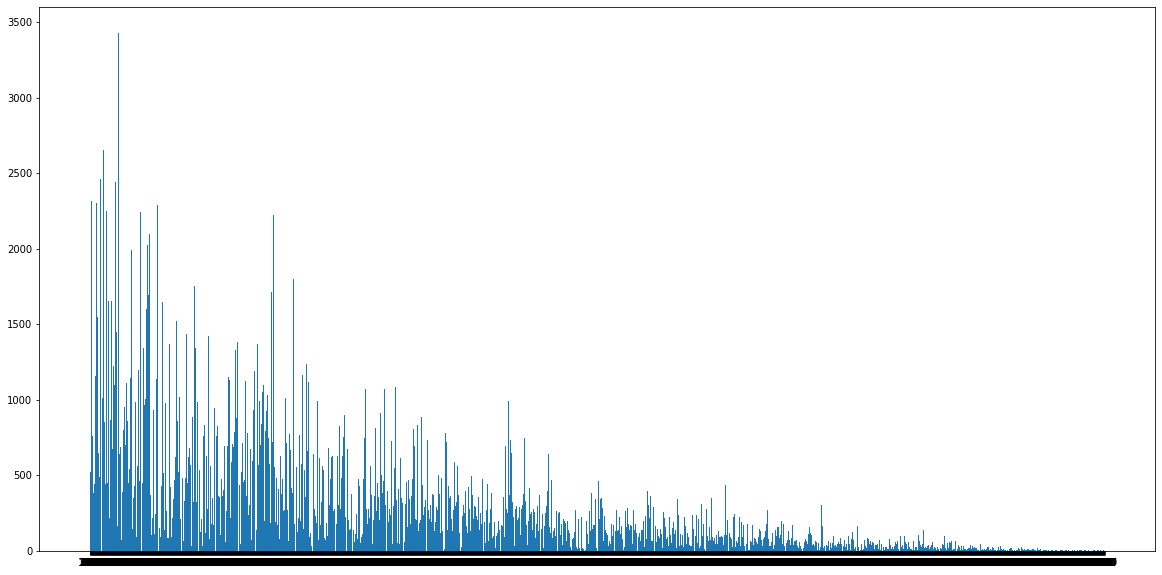

In [31]:
# 사용자가 선택한 영화 분포 확인
plt.figure(figsize=(20,10))
plt.hist(ratings_df["MovieID"], bins=3883)
plt.show()

In [32]:
# 결측치 확인
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [69]:
# 최대값 확인
print(len(set(ratings_df["UserID"])) == max([int(i) for i in set(ratings_df["UserID"])]))
print(max([int(i) for i in set(ratings_df["UserID"])]))

True
6040


In [70]:
ratings_df = ratings_df.applymap(int)

In [78]:
# 유저별로 본 영화들 순서대로 정리
users_dict = {user : [] for user in set(ratings_df["UserID"])}
users_dict[1]

[]

In [80]:
# 시간 순으로 정렬하기
ratings_df = ratings_df.sort_values(by='Timestamp', ascending=True)
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000192,6040,2019,5,956703977
1000007,6040,1961,4,956703977


In [205]:
# 유저 딕셔너리에 (영화, 평점)쌍 넣기
ratings_df_gen = ratings_df.iterrows()
for data in ratings_df_gen:
    users_dict[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))
users_dict[1]

[(3186, 4),
 (1270, 5),
 (1022, 5),
 (1721, 4),
 (2340, 3),
 (1836, 5),
 (3408, 4),
 (2804, 5),
 (1207, 4),
 (260, 4),
 (1193, 5),
 (720, 3),
 (919, 4),
 (608, 4),
 (2692, 4),
 (1961, 5),
 (2028, 5),
 (3105, 5),
 (938, 4),
 (1035, 5),
 (1962, 4),
 (150, 5),
 (2018, 4),
 (1028, 5),
 (1097, 4),
 (914, 3),
 (1287, 5),
 (2797, 4),
 (2762, 4),
 (1246, 4),
 (661, 3),
 (2918, 4),
 (531, 4),
 (3114, 4),
 (2791, 4),
 (2321, 3),
 (1029, 5),
 (594, 4),
 (1197, 3),
 (2398, 4),
 (1545, 4),
 (527, 5),
 (588, 4),
 (745, 3),
 (2687, 3),
 (1, 5),
 (595, 5),
 (2294, 4),
 (783, 4),
 (2355, 5),
 (1907, 4),
 (1566, 4),
 (48, 5)]

In [208]:
# 각 유저별 영화 히스토리 길이
users_history_len = [len(users_dict[u]) for u in set(ratings_df["UserID"])]
users_history_len[:10]

[53, 129, 51, 21, 198, 71, 31, 139, 106, 401]

In [ ]:
# 준비된것
## users_dict, users_history_len, movies_id_to_movies

In [283]:
users_dict[1][:5]

[(3186, 4), (1270, 5), (1022, 5), (1721, 4), (2340, 3)]

In [356]:
class OfflineEnv(object):
    
    def __init__(self, users_dict, users_history_len, movies_id_to_movies, state_size, user_id=None):
        
        self.users_dict = users_dict
        self.users_history_len = users_history_len
        self.items_id_to_name = movies_id_to_movies
        
        self.state_size = state_size
        self.available_users = self._generate_available_users()
        
        self.user = user_id if user_id else np.random.choice(self.available_users)
        self.user_items = {data[0]:data[1] for data in self.users_dict[self.user]}
        self.state = [data[0] for data in self.users_dict[self.user][:self.state_size]]
        self.done = False
        self.recommended_items = set(self.state)
        
    def _generate_available_users(self):
        available_users = []
        for i, length in enumerate(self.users_history_len):
            if length > self.state_size:
                available_users.append(i+1)
        return available_users
    
    def reset(self, user_id=None):
        self.user = user_id if user_id else np.random.choice(self.available_users)
        self.state = [data[0] for data in self.users_dict[self.user][:self.state_size]]
        self.done = False
        self.recommended_items = set(self.state)
        
    def step(self, action):

        reward = 0
        
        if action in self.user_items.keys() and action not in self.recommended_items:
            reward = self.user_items[action] - 2  # reward function
            del self.user_items[action]
        
        if reward > 0:
            self.state = self.state[1:] + [action]
        
        self.recommended_items.add(action)
        if self.user_items == {}:
            self.done == True
        
        return self.state, reward, self.done, self.recommended_items

In [357]:
env = OfflineEnv(users_dict, users_history_len, movies_id_to_movies, 10, user_id=None)

# State Representation Models

In [ ]:
class Embedding(tf.keras.Model):
    def __init__(self, users_num, items_num, embedding_dim):
        super(Embedding, self).__init__()
        self.user_eb = tf.keras.layers.Embedding(users_num, embedding_dim)
        self.item_eb = tf.keras.layers.Embedding(items_num, embedding_dim)
        
    def call(self, user_id, items_ids):
        return self.user_eb(user_id), self.item_eb(item_id)
    
    def _get_item_eb(self, items_ids):
        return self.item_eb(items_ids)

In [ ]:
class DRRAveStateRepresentation(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(DDRAveStateRepresentation, self).__init__()
        self.wav = tf.keras.layers.Conv1D(embedding_dim, 1, 1)
        
    def call(self, user_eb, items_eb):
        wav = self.wav(items_eb)
        user_wav = tf.keras.layers.multiply([user_eb, wav])
        concat = tf.keras.layers.Concatenate([user, user_wav, wav])
        return concat

# Actor, Critic Module

In [ ]:
class ActorNetwork(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_dim):
        super(ActorNetwork, self).__init__()
        self.srm = DRRAveStateRepresentation(embedding_dim)
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(embedding_dim, activation='tanh')
        ])
    def call(self, user_eb, items_ebs):
        state = self.srm(user_eb, items_ebs)
        return self.fc(state), state

### Actor를 설정할 때 2가지 방법으로 나뉨

1. embedding 포함
2. embedding 미포함

#### Embedding 포함 

state가 사실상 (user_id, items_ids)

In [ ]:
class Actor(object):
    
    def __init__(self, users_num, items_num, embedding_dim, hidden_dim, learning_rate, tau):
        
        self.items_num = items_num
        
        # 임베딩 네트워크
        self.embedding_network = Embedding(users_num, items_num, embedding_dim)
        # 엑터 네트워크 / 타겟 네트워크
        self.network = ActorNetwork(embedding_dim, hidden_dim)
        self.target_network = ActorNetwork(embedding_dim, hidden_dim)
        # 옵티마이저
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # 소프트 타겟 네트워크 업데이트 하이퍼파라미터
        self.tau = tau
        
    def get_action(self, weight, items_ids=None):
        if items_ids == None:
            items_ids = [i for i in range(self.items_num)]
        items_ebs = self.embedding_network._get_item_eb(items_ids)
        item_idx = np.argmax(tf.keras.backend.dot(items_ebs, weight))
        return items_ids[item_idx]
    
    def update_target_network(self):
        # 소프트 타겟 네트워크 업데이트
        c_theta, t_theta = self.network.get_weights(), self.target_network.get_weights()
        for i in range(len(c_theta)):
            t_theta[i] = self.tau * c_theta[i] + (1 - self.tau) * t_theta[i]
        self.target_network.set_weights(t_theta)
        
    def train(self, user_id, items_ids, values, dq_das):
        with tf.GradientTape() as g:
            user_eb, items_ebs = self.embedding_network(user_id, items_ids)
            weight, _ = self.network(user_eb, items_ebs)
            obj = np.mean(values * weight, axis=1)
        dj_dtheta = g.gradient(obj, self.network.trainable_weights, -dq_das)
        grads = zip(dj_dtheta, self.network.trainable_weights)
        self.optimizer.apply_gradients(grads)
        
    def save_weights(self, path):
        self.network.save_weights(path)
        
    def load_weights(self, path):
        self.network.load_weights(path)

In [ ]:
class CriticNetwork(tf.keras.Model):
    def __init__(self, hidden_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.concat = tf.keras.layers.Concatenate()
        self.fc2 = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation = 'relu'),
            tf.keras.layers.Dense(1, activation = 'relu')
        ])
        
    def call(self, state, action):
        fc1 = self.fc1(state)
        concat = self.concat([action, state])
        return self.fc2(concat)

In [ ]:
class Critic(object):
    
    def __init__(self, hidden_dim, learning_rate, tau):
        # 크리틱 네트워크 / 타겟 네트워크
        self.network = CriticNetwork(hidden_dim)
        self.target_network = CriticNetwork(hidden_dim)
        # 네트워크 컴파일
        self.network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                             loss='mse')
        self.target_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                    loss='mse')
        # 소프트 타겟 네트워크 업데이트 하이퍼파라미터
        self.tau = tau
        
    def update_target_network(self):
        c_omega = self.network.get_weights()
        t_omega = self.target_network.get_weights()
        for i in range(len(c_omega)):
            t_omega[i] = self.tau * c_omega[i] + (1 - self.tau) * t_omega[i]
        self.target_network.set_weights(t_omega)
        
    def dq_da(self, states, weights):
        with tf.GradientTape() as g:
            actions = tf.convert_to_tensor(weights)
            g.watch(weights)
            outputs = self.network(state, weights)
        q_grads = g.gradient(outputs, weights)
        return q_grads
    
    def train_on_batch(self, states, weights, td_targets):
        self.network.train_on_batch([states, weights], td_targets)
            
    def save_weights(self, path):
        self.network.save_weights(path)
        
    def load_weights(self, path):
        self.network.load_weights(path)

In [ ]:
class ReplayMemory(object):
    def __init__(self, replay_memory_size, state_size):
        self.rm_size = replay_memory_size
        self.crt_idx = 0
        
        '''
            user_id : (1,), 
            items_ids : (10,) 변할 수 잇음, 
            actions : (1,), 
            rewards : (1,), 
            next_user_id : (1,), 
            next_items_ids : (10,), 
            dones : (1,)
        '''
    
        self.users_ids = np.zeros((replay_memory_size, 1), dtype=np.uint8)
        self.items_ids = np.zeros((replay_memory_size, state_size), dtype=np.uint8)
        self.actions = np.zeros((replay_memory_size, 1), dtype=np.uint8)
        self.rewards = np.zeros((replay_memory_size, 1), dtype=np.uint8)
        self.rewards[-1] = 777
        self.next_users_ids = np.zeros((replay_memory_size, 1), dtype=np.uint8)
        self.next_items_ids = np.zeros((replay_memory_size, state_size), dtype=np.uint8)
        self.dones = np.zeros(replay_memory_size, np.bool)

    def is_full(self):
        return self.rewards[-1] != 777

    def append(self, user_id, items_ids, action, rewards, next_user_id, next_items_ids, done):
        self.users_ids[self.crt_idx] = user_id
        self.items_ids[self.crt_idx] = items_ids
        self.actions[self.crt_idx] = action
        self.rewards[self.crt_idx] = rewards
        self.next_users_ids[self.crt_idx] = next_user_id
        self.next_items_ids[self.crt_idx] = next_items_ids
        self.dones[self.crt_idx] = done

        self.crt_idx = (self.crt_idx + 1) % self.rm_size

    def sample(self, batch_size):
        rd_idx = np.random.choice((1 - self.is_full())*self.crt_idx+self.is_full()*self.rm_size, batch_size)
        batch_users_ids = users_ids[rd_idx]
        batch_items_ids = items_ids[rd_idx]
        batch_actions = actions[rd_idx]
        batch_rewards = rewards[rd_idx]
        batch_next_users_ids = next_users_ids[rd_idx]
        batch_next_items_ids = next_items_ids[rd_idx]
        batch_dones = dones[rd_idx]

        return batch_users_ids, batch_items_ids, batch_actions, batch_rewards, batch_next_users_ids, batch_next_items_ids, batch_dones

In [ ]:
class DRRAgent:
    
    def __init__(self, users_num, items_num):

        self.users_num = users_num
        self.items_num = items_num
        
        self.embedding_dim = 16
        self.actor_hidden_dim = 32
        self.actor_learning_rate = 0.001
        self.critic_hidden_dim = 32
        self.critic_learning_rate = 0.001
        self.discount_factor = 0.9
        self.tau = 0.001
        
        self.actor = Actor(users_num, items_num, self.embedding_dim, self.actor_hidden_dim, self.actor_learning_rate, self.tau)
        self.critic = Critic(self.critic_hidden_dim, self.learning_rate, self.tau)
        
        self.buffer = ReplayMemory(replay_memory_size, state_size)
        
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho*(mu - x)*dt + sigma*np.sqrt(dt)*np.random.normal(size=dim)
    
    def td_target(self, rewards, q_values, dones):
        y_t = np.asarray(q_values)
        for i in range(q_values.shape[0]):
            y_t = rewards[i] + (1 - dones[i])*(self.discount_factor * q_values[i])
        return y_t
        
    def save_model(self, actor_path, critic_path):
        self.actor.save_weights(actor_path)
        self.critic.save_weights(critic_path)
        
    def load_model(self, actor_path, critic_path):
        self.actor.load_weights(actor_path)
        self.critic.load_weights(critic_path)